In [1]:
import importlib
import logging
import nanomotif as nm
from nanomotif.candidate import Motif
import polars as pl
from polars import col, lit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
importlib.reload(nm)


<module 'nanomotif' from '/user_data/sh/dark-science/nanomotif/nanomotif/__init__.py'>

In [2]:
assembly = nm.load_assembly("../../data/mruber/assembly.polished.fasta")
mruber = nm.load_pileup("../../data/mruber/modkit.pileup.bed").pileup \
    .filter(pl.col("contig") == "contig_1") \
    .filter(pl.col("mod_type") == "a") \
    .filter(pl.col("Nvalid_cov") > 10) \
    .filter(pl.col("fraction_mod") > 0.9) 

In [3]:
sequence = assembly.assembly["contig_1"]
padding = 1
index_fwd = mruber.filter(pl.col("strand") == "+").get_column("position").to_list()
index_rev = mruber.filter(pl.col("strand") == "-").get_column("position").to_list()
sequences_fwd = sequence.sample_at_indices(index_fwd, padding)
# sequences_rev = sequence.sample_at_indices(index_rev, padding).reverse_compliment() 
methylation_sequences = sequences_fwd

In [4]:
with open("meth_seqs.fasta", "w") as f:
    for i, seq in enumerate(methylation_sequences.sequences[0:500]):
        f.write(f">seq_{i}\n")
        f.write(f"{seq.sequence}\n")

In [5]:
import Bio.Align.Applications
from Bio.Align.Applications import ClustalwCommandline
cline = ClustalwCommandline("/shared_software/arb/bin/clustalw", infile="meth_seqs.fasta")
stdout, stderr =  cline()

In [6]:
from Bio import AlignIO
from Bio.Phylo.Consensus import *
align = AlignIO.read("meth_seqs.aln", "clustal")
align_s = bootstrap(align, 100)

DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG: findfont: score(FontEntry(fname='/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: findfont: score(FontEntry(fname='/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG: findfont: score(FontEntry(fname='/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', nam

DEBUG: findfont: score(FontEntry(fname='/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: findfont: score(FontEntry(fname='/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG: findfont: score(FontEntry(fname='/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: findfont: score(FontEntry(fname='/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='c

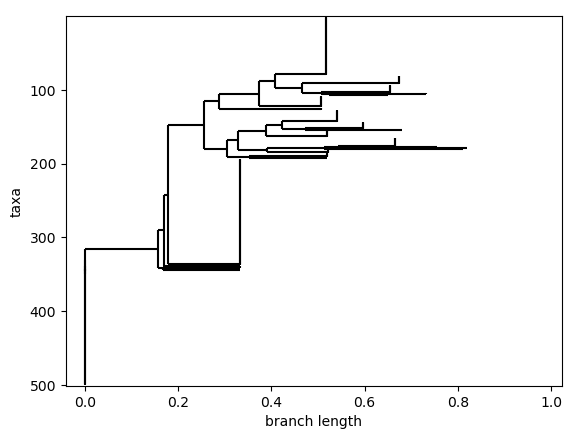

In [7]:
from Bio import Phylo
tree = Phylo.read("meth_seqs.dnd", "newick")
Phylo.draw(tree, label_func=lambda x: "", do_show=False)

In [8]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
aln = AlignIO.read(open('meth_seqs.aln'), 'clustal')
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(aln)


In [9]:
dm

DistanceMatrix(names=['seq_1', 'seq_5', 'seq_17', 'seq_20', 'seq_36', 'seq_76', 'seq_119', 'seq_125', 'seq_161', 'seq_179', 'seq_183', 'seq_388', 'seq_394', 'seq_397', 'seq_416', 'seq_449', 'seq_18', 'seq_112', 'seq_131', 'seq_132', 'seq_212', 'seq_329', 'seq_357', 'seq_410', 'seq_418', 'seq_488', 'seq_335', 'seq_72', 'seq_136', 'seq_283', 'seq_300', 'seq_350', 'seq_374', 'seq_376', 'seq_440', 'seq_459', 'seq_463', 'seq_0', 'seq_3', 'seq_6', 'seq_10', 'seq_23', 'seq_26', 'seq_27', 'seq_28', 'seq_30', 'seq_39', 'seq_41', 'seq_45', 'seq_48', 'seq_49', 'seq_51', 'seq_53', 'seq_56', 'seq_67', 'seq_68', 'seq_82', 'seq_87', 'seq_99', 'seq_107', 'seq_109', 'seq_116', 'seq_130', 'seq_139', 'seq_140', 'seq_162', 'seq_172', 'seq_181', 'seq_184', 'seq_196', 'seq_207', 'seq_209', 'seq_213', 'seq_223', 'seq_243', 'seq_244', 'seq_245', 'seq_250', 'seq_257', 'seq_261', 'seq_263', 'seq_270', 'seq_271', 'seq_276', 'seq_285', 'seq_292', 'seq_307', 'seq_311', 'seq_317', 'seq_319', 'seq_324', 'seq_325', '

# Edit distance clustering

In [10]:
import editdistance
import seaborn as sns
def edit_distance(sequences):
    n = len(sequences)
    distances = np.empty(shape = (n, n), dtype=np.int16)
    for i in range(0, n):
        for j in range(i, n):
            d = editdistance.eval(sequences[i], sequences[j])
            distances[i, j] = float(d)
            distances[j, i] = float(d)
    return distances

In [11]:
sequences = methylation_sequences.sequences[1000:2000]
dists = edit_distance(sequences);

/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkag

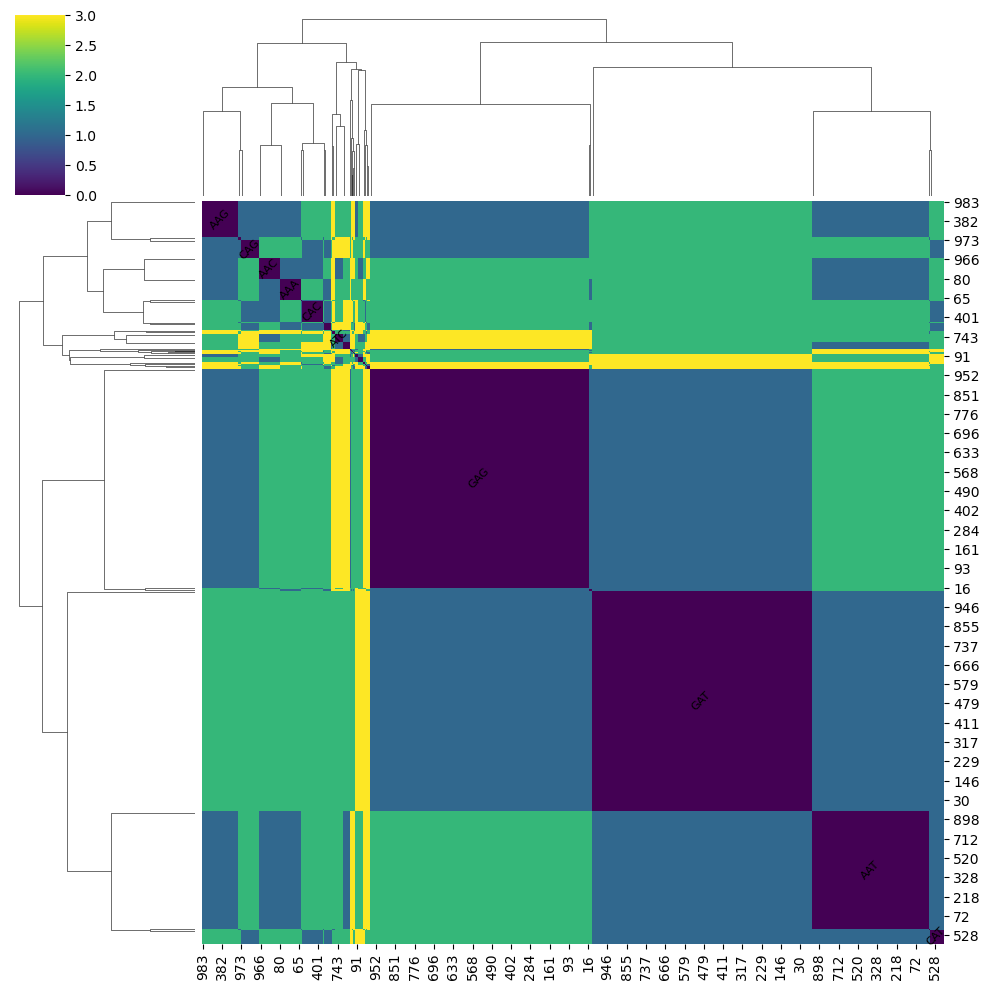

In [12]:
a =sns.clustermap(dists, cmap="viridis", figsize=(10, 10))
heatmap_data =  a.data2d.to_numpy()

# Initialise dictionary of identical sequences
identical_sequences_index = {} 
group_start = 0
identical_sequences_index[group_start] = [0]

# Iterate over the diagonal of the heatmap
for i in range(heatmap_data.shape[0] - 1):
    # if the next diagonal element is different, start a new group
    if heatmap_data[i, i] != heatmap_data[i-1, i]:
        group_start = i
        identical_sequences_index[group_start] = [i]
    else:
        identical_sequences_index[group_start] = identical_sequences_index[group_start] + [i]

# Annotate heatmap with identical sequences
for k, v in identical_sequences_index.items():
    if len(v) > 10:
        seq = "".join((sequences[a.dendrogram_col.reordered_ind[k]]))
        x_plot = v[int(len(v)/2)]
        a.figure.axes[2].text(x_plot, x_plot, f"{seq}", fontsize=8, ha='center', va="center", rotation=45)

In [13]:
import hdbscan
import pandas as pd
clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=30, min_samples=50)
clusterer.fit(np.array(dists, dtype=np.float64))
clusters = pd.Series(clusterer.labels_)
print(len(clusters.unique()))
colors = sns.color_palette("hls", len(clusters.unique()))
lut = dict(zip(clusters.unique(), colors))
cluster_colors = clusters.map(lut)

5


/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkag

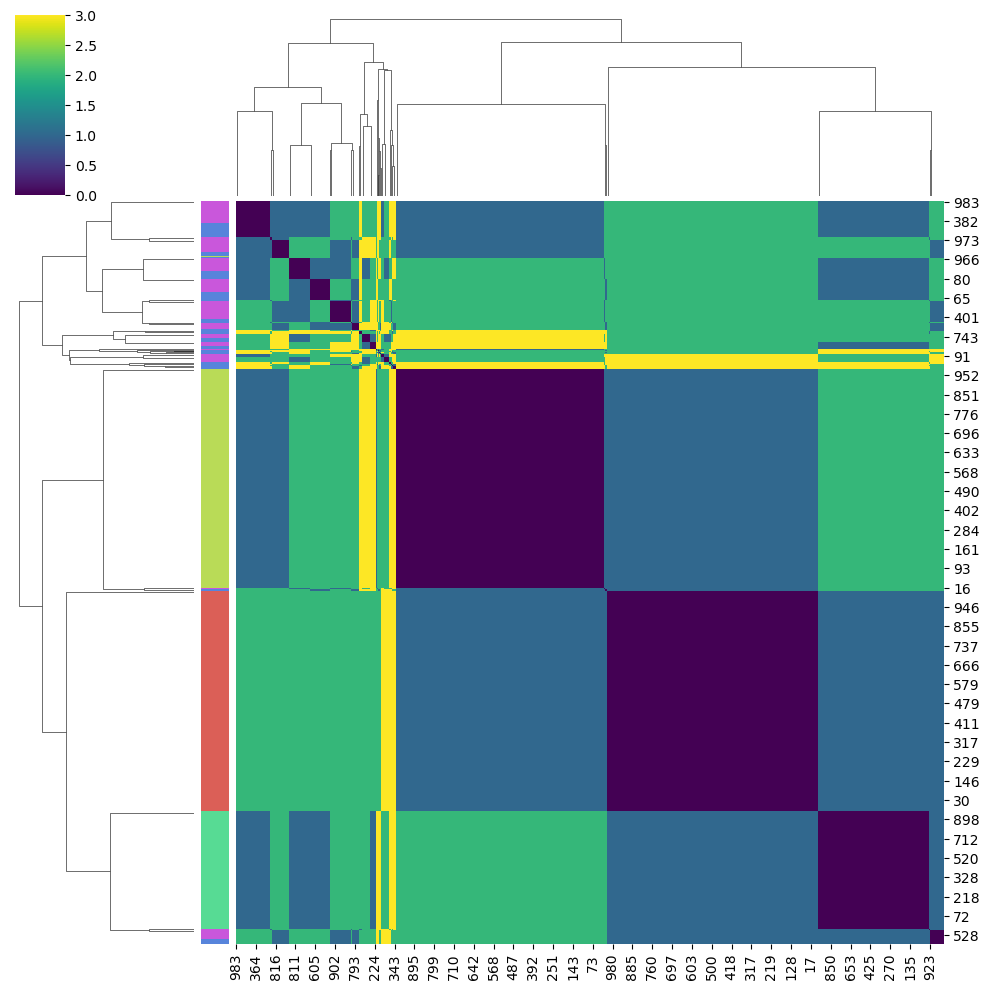

In [14]:
a =sns.clustermap(dists, cmap="viridis", figsize=(10, 10), row_colors=cluster_colors.to_numpy())
heatmap_data =  a.data2d.to_numpy()

## Initialise dictionary of identical sequences
#identical_sequences_index = {} 

#group_start = 0
#identical_sequences_index[group_start] = [0]
#
## Iterate over the diagonal of the heatmap
#for i in range(heatmap_data.shape[0] - 1):
#    # if the next diagonal element is different, start a new group
#    if heatmap_data[i, i] != heatmap_data[i+1, i]:
#        group_start = i
#        identical_sequences_index[group_start] = [i]
#    else:
#        identical_sequences_index[group_start] = identical_sequences_index[group_start] + [i]
#
## Annotate heatmap with identical sequences
#for k, v in identical_sequences_index.items():
#    if len(v) > 10:
#        seq = "".join((sequences[a.dendrogram_col.reordered_ind[k]]))
#        x_plot = v[int(len(v)/2)]
#        a.figure.axes[2].text(x_plot, x_plot, f"{seq}", fontsize=8, ha='center', va="center", rotation=45)